# 第6章 缺失数据

#### 在接下来的两章中，会接触到数据预处理中比较麻烦的类型，即缺失数据和文本数据（尤其是混杂型文本）
#### Pandas在步入1.0后，对数据类型也做出了新的尝试，尤其是Nullable类型和String类型，了解这些可能在未来成为主流的新特性是必要的

In [3]:
!pip install --upgrade pip
!pip install pandas==1.0.5 -i https://mirrors.huaweicloud.com/repository/pypi/simple

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Requirement already up-to-date: pip in /home/ma-user/anaconda3/lib/python3.6/site-packages (20.1.1)
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 10.1 MB 462 kB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [4]:
import pandas as pd
pd.__version__

'1.0.5'

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/table_missing.csv')
df.head()

,School,Class,ID,Gender,Address,Height,Weight,Math,Physics
0,S_1,C_1,NaN,M,street_1,173,NaN,34.0,A+
1,S_1,C_1,NaN,F,street_2,192,NaN,32.5,B+
2,S_1,C_1,1103.0,M,street_2,186,NaN,87.2,B+
3,S_1,NaN,NaN,F,street_2,167,81.0,80.4,NaN
4,S_1,C_1,1105.0,NaN,street_4,159,64.0,84.8,A-


## 一、缺失观测及其类型

### 1. 了解缺失信息
#### （a）isna和notna方法
#### 对Series使用会返回布尔列表

In [6]:
df['Physics'].isna().head()

0    False
1    False
2    False
3     True
4    False
Name: Physics, dtype: bool

In [7]:
df['Physics'].notna().head()

0     True
1     True
2     True
3    False
4     True
Name: Physics, dtype: bool

#### 对DataFrame使用会返回布尔表

In [8]:
df.isna().head()

,School,Class,ID,Gender,Address,Height,Weight,Math,Physics
0,False,False,True,False,False,False,True,False,False
1,False,False,True,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False
3,False,True,True,False,False,False,False,False,True
4,False,False,False,True,False,False,False,False,False


#### 但对于DataFrame我们更关心到底每列有多少缺失值

In [9]:
df.isna().sum()

School      0
Class       4
ID          6
Gender      7
Address     0
Height      0
Weight     13
Math        5
Physics     4
dtype: int64

#### 此外，可以通过第1章中介绍的info函数查看缺失信息

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   School   35 non-null     object 
 1   Class    31 non-null     object 
 2   ID       29 non-null     float64
 3   Gender   28 non-null     object 
 4   Address  35 non-null     object 
 5   Height   35 non-null     int64  
 6   Weight   22 non-null     float64
 7   Math     30 non-null     float64
 8   Physics  31 non-null     object 
dtypes: float64(3), int64(1), object(5)
memory usage: 2.6+ KB


#### （b）查看缺失值的所以在行

#### 以最后一列为例，挑出该列缺失值的行

In [11]:
df[df['Physics'].isna()]

,School,Class,ID,Gender,Address,Height,Weight,Math,Physics
3,S_1,NaN,NaN,F,street_2,167,81.0,80.4,NaN
8,S_1,C_2,1204.0,F,street_5,162,63.0,33.8,NaN
13,S_1,C_3,1304.0,NaN,street_2,195,70.0,85.2,NaN
22,S_2,C_2,2203.0,M,street_4,155,91.0,73.8,NaN


#### （c）挑选出所有非缺失值列
#### 使用all就是全部非缺失值，如果是any就是至少有一个不是缺失值

In [12]:
df[df.notna().all(1)]

,School,Class,ID,Gender,Address,Height,Weight,Math,Physics
5,S_1,C_2,1201.0,M,street_5,159,68.0,97.0,A-
6,S_1,C_2,1202.0,F,street_4,176,94.0,63.5,B-
12,S_1,C_3,1303.0,M,street_7,188,82.0,49.7,B
17,S_2,C_1,2103.0,M,street_4,157,61.0,52.5,B-
21,S_2,C_2,2202.0,F,street_7,194,77.0,68.5,B+
25,S_2,C_3,2301.0,F,street_4,157,78.0,72.3,B+
27,S_2,C_3,2303.0,F,street_7,190,99.0,65.9,C
28,S_2,C_3,2304.0,F,street_6,164,81.0,95.5,A-
29,S_2,C_3,2305.0,M,street_4,187,73.0,48.9,B


### 2. 三种缺失符号
#### （a）np.nan
#### np.nan是一个麻烦的东西，首先它不等与任何东西，甚至不等于自己

In [13]:
np.nan == np.nan

False

In [14]:
np.nan == 0

False

In [15]:
np.nan == None

False

#### 在用equals函数比较时，自动略过两侧全是np.nan的单元格，因此结果不会影响

In [16]:
df.equals(df)

True

#### 其次，它在numpy中的类型为浮点，由此导致数据集读入时，即使原来是整数的列，只要有缺失值就会变为浮点型

In [17]:
type(np.nan)

float

In [18]:
pd.Series([1,2,3]).dtype

dtype('int64')

In [19]:
pd.Series([1,np.nan,3]).dtype

dtype('float64')

#### 此外，对于布尔类型的列表，如果是np.nan填充，那么它的值会自动变为True而不是False

In [20]:
pd.Series([1,np.nan,3],dtype='bool')

0    True
1    True
2    True
dtype: bool

#### 但当修改一个布尔列表时，会改变列表类型，而不是赋值为True

In [21]:
s = pd.Series([True,False],dtype='bool')
s[1]=np.nan
s

0    1.0
1    NaN
dtype: float64

#### 在所有的表格读取后，无论列是存放什么类型的数据，默认的缺失值全为np.nan类型
#### 因此整型列转为浮点；而字符由于无法转化为浮点，因此只能归并为object类型（'O'），原来是浮点型的则类型不变

In [22]:
df['ID'].dtype

dtype('float64')

In [23]:
df['Math'].dtype

dtype('float64')

In [24]:
df['Class'].dtype

dtype('O')

#### （b）None
#### None比前者稍微好些，至少它会等于自身

In [25]:
None == None

True

#### 它的布尔值为False

In [26]:
pd.Series([None],dtype='bool')

0    False
dtype: bool

#### 修改布尔列表不会改变数据类型

In [27]:
s = pd.Series([True,False],dtype='bool')
s[0]=None
s

0    False
1    False
dtype: bool

In [28]:
s = pd.Series([1,0],dtype='bool')
s[0]=None
s

0    False
1    False
dtype: bool

#### 在传入数值类型后，会自动变为np.nan

In [29]:
type(pd.Series([1,None])[1])

numpy.float64

#### 只有当传入object类型是保持不动，几乎可以认为，除非人工命名None，它基本不会自动出现在Pandas中

In [30]:
type(pd.Series([1,None],dtype='O')[1])

NoneType

####  在使用equals函数时不会被略过，因此下面的情况下返回False

In [31]:
pd.Series([None]).equals(pd.Series([np.nan]))

False

#### （c）NaT
#### NaT是针对时间序列的缺失值，是Pandas的内置类型，可以完全看做时序版本的np.nan，与自己不等，且使用equals是也会被跳过

In [32]:
s_time = pd.Series([pd.Timestamp('20120101')]*5)
s_time

0   2012-01-01
1   2012-01-01
2   2012-01-01
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [33]:
s_time[2] = None
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [34]:
s_time[2] = np.nan
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [35]:
s_time[2] = pd.NaT
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [36]:
type(s_time[2])

pandas._libs.tslibs.nattype.NaTType

In [37]:
s_time[2] == s_time[2]

False

In [38]:
s_time.equals(s_time)

True

In [39]:
s = pd.Series([True,False],dtype='bool')
s[1]=pd.NaT
s

0    True
1    True
dtype: bool

### 3. Nullable类型与NA符号
#### 这是Pandas在1.0新版本中引入的重大改变，其目的就是为了（在若干版本后）解决之前出现的混乱局面，统一缺失值处理方法
#### "The goal of pd.NA is provide a “missing” indicator that can be used consistently across data types (instead of np.nan, None or pd.NaT depending on the data type)."——User Guide for Pandas v-1.0
#### 官方鼓励用户使用新的数据类型和缺失类型pd.NA

#### （a）Nullable整形
#### 对于该种类型而言，它与原来标记int上的符号区别在于首字母大写：'Int'

In [40]:
s_original = pd.Series([1, 2], dtype="int64")
s_original

0    1
1    2
dtype: int64

In [41]:
s_new = pd.Series([1, 2], dtype="Int64")
s_new

0    1
1    2
dtype: Int64

#### 它的好处就在于，其中前面提到的三种缺失值都会被替换为统一的NA符号，且不改变数据类型

In [42]:
s_original[1] = np.nan
s_original

0    1.0
1    NaN
dtype: float64

In [43]:
s_new[1] = np.nan
s_new

0       1
1    <NA>
dtype: Int64

In [44]:
s_new[1] = None
s_new

0       1
1    <NA>
dtype: Int64

In [45]:
s_new[1] = pd.NaT
s_new

0       1
1    <NA>
dtype: Int64

#### （b）Nullable布尔
#### 对于该种类型而言，作用与上面的类似，记号为boolean

In [46]:
s_original = pd.Series([1, 0], dtype="bool")
s_original

0     True
1    False
dtype: bool

In [47]:
s_new = pd.Series([0, 1], dtype="boolean")
s_new

0    False
1     True
dtype: boolean

In [48]:
s_original[0] = np.nan
s_original

0    NaN
1    0.0
dtype: float64

In [49]:
s_original = pd.Series([1, 0], dtype="bool") #此处重新加一句是因为前面赋值改变了bool类型
s_original[0] = None
s_original

0    False
1    False
dtype: bool

In [50]:
s_new[0] = np.nan
s_new

0    <NA>
1    True
dtype: boolean

In [51]:
s_new[0] = None
s_new

0    <NA>
1    True
dtype: boolean

In [52]:
s_new[0] = pd.NaT
s_new

0    <NA>
1    True
dtype: boolean

#### 需要注意的是，含有pd.NA的布尔列表在1.0.2之前的版本作为索引时会报错，这是一个之前的[bug](https://pandas.pydata.org/docs/whatsnew/v1.0.2.html#indexing-with-nullable-boolean-arrays)，现已经修复

In [53]:
s = pd.Series(['dog','cat'])
s[s_new]

1    cat
dtype: object

#### （c）string类型
#### 该类型是1.0的一大创新，目的之一就是为了区分开原本含糊不清的object类型，这里将简要地提及string，因为它是第7章的主题内容
#### 它本质上也属于Nullable类型，因为并不会因为含有缺失而改变类型

In [54]:
s = pd.Series(['dog','cat'],dtype='string')
s

0    dog
1    cat
dtype: string

In [55]:
s[0] = np.nan
s

0    <NA>
1     cat
dtype: string

In [56]:
s[0] = None
s

0    <NA>
1     cat
dtype: string

In [57]:
s[0] = pd.NaT
s

0    <NA>
1     cat
dtype: string

#### 此外，和object类型的一点重要区别就在于，在调用字符方法后，string类型返回的是Nullable类型，object则会根据缺失类型和数据类型而改变

In [58]:
s = pd.Series(["a", None, "b"], dtype="string")
s.str.count('a')

0       1
1    <NA>
2       0
dtype: Int64

In [59]:
s2 = pd.Series(["a", None, "b"], dtype="object")
s2.str.count("a")

0    1.0
1    NaN
2    0.0
dtype: float64

In [60]:
s.str.isdigit()

0    False
1     <NA>
2    False
dtype: boolean

In [61]:
s2.str.isdigit()

0    False
1     None
2    False
dtype: object

### 4. NA的特性

#### （a）逻辑运算
#### 只需看该逻辑运算的结果是否依赖pd.NA的取值，如果依赖，则结果还是NA，如果不依赖，则直接计算结果

In [62]:
True | pd.NA

True

In [63]:
pd.NA | True

True

In [64]:
False | pd.NA

<NA>

In [65]:
False & pd.NA

False

In [66]:
True & pd.NA

<NA>

#### 取值不明直接报错

In [67]:
bool(pd.NA)

TypeError: boolean value of NA is ambiguous

#### （b）算术运算和比较运算
#### 这里只需记住除了下面两类情况，其他结果都是NA即可

In [68]:
pd.NA ** 0

1

In [69]:
1 ** pd.NA

1

#### 其他情况：

In [70]:
pd.NA + 1

<NA>

In [71]:
"a" * pd.NA

<NA>

In [72]:
pd.NA == pd.NA

<NA>

In [73]:
pd.NA < 2.5

<NA>

In [74]:
np.log(pd.NA)

<NA>

In [75]:
np.add(pd.NA, 1)

<NA>

### 5.  convert_dtypes方法
#### 这个函数的功能往往就是在读取数据时，就把数据列转为Nullable类型，是1.0的新函数

In [76]:
pd.read_csv('data/table_missing.csv').dtypes

School      object
Class       object
ID         float64
Gender      object
Address     object
Height       int64
Weight     float64
Math       float64
Physics     object
dtype: object

In [77]:
pd.read_csv('data/table_missing.csv').convert_dtypes().dtypes

School      string
Class       string
ID           Int64
Gender      string
Address     string
Height       Int64
Weight       Int64
Math       float64
Physics     string
dtype: object

## 二、缺失数据的运算与分组

### 1. 加号与乘号规则

#### 使用加法时，缺失值为0

In [78]:
s = pd.Series([2,3,np.nan,4])
s.sum()

9.0

#### 使用乘法时，缺失值为1

In [79]:
s.prod()

24.0

#### 使用累计函数时，缺失值自动略过

In [80]:
s.cumsum()

0    2.0
1    5.0
2    NaN
3    9.0
dtype: float64

In [81]:
s.cumprod()

0     2.0
1     6.0
2     NaN
3    24.0
dtype: float64

In [82]:
s.pct_change()

0         NaN
1    0.500000
2    0.000000
3    0.333333
dtype: float64

### 2. groupby方法中的缺失值
#### 自动忽略为缺失值的组

In [83]:
df_g = pd.DataFrame({'one':['A','B','C','D',np.nan],'two':np.random.randn(5)})
df_g

,one,two
0,A,-0.883048
1,B,-0.629075
2,C,0.197589
3,D,-0.557765
4,NaN,-1.385495


In [84]:
df_g.groupby('one').groups

{'A': Int64Index([0], dtype='int64'),
 'B': Int64Index([1], dtype='int64'),
 'C': Int64Index([2], dtype='int64'),
 'D': Int64Index([3], dtype='int64')}

## 三、填充与剔除

### 1. fillna方法

#### （a）值填充与前后向填充（分别与ffill方法和bfill方法等价）

In [85]:
df['Physics'].fillna('missing').head()

0         A+
1         B+
2         B+
3    missing
4         A-
Name: Physics, dtype: object

In [86]:
df['Physics'].fillna(method='ffill').head()

0    A+
1    B+
2    B+
3    B+
4    A-
Name: Physics, dtype: object

In [87]:
df['Physics'].fillna(method='backfill').head()

0    A+
1    B+
2    B+
3    A-
4    A-
Name: Physics, dtype: object

#### （b）填充中的对齐特性

In [88]:
df_f = pd.DataFrame({'A':[1,3,np.nan],'B':[2,4,np.nan],'C':[3,5,np.nan]})
df_f.fillna(df_f.mean())

,A,B,C
0,1.0,2.0,3.0
1,3.0,4.0,5.0
2,2.0,3.0,4.0


#### 返回的结果中没有C，根据对齐特点不会被填充

In [89]:
df_f.fillna(df_f.mean()[['A','B']])

,A,B,C
0,1.0,2.0,3.0
1,3.0,4.0,5.0
2,2.0,3.0,NaN


### 2. dropna方法

#### （a）axis参数

In [90]:
df_d = pd.DataFrame({'A':[np.nan,np.nan,np.nan],'B':[np.nan,3,2],'C':[3,2,1]})
df_d

,A,B,C
0,NaN,NaN,3
1,NaN,3.0,2
2,NaN,2.0,1


In [91]:
df_d.dropna(axis=0)

,A,B,C


In [92]:
df_d.dropna(axis=1)

,C
0,3
1,2
2,1


#### （b）how参数（可以选all或者any，表示全为缺失去除和存在缺失去除）

In [93]:
df_d.dropna(axis=1,how='all')

,B,C
0,NaN,3
1,3.0,2
2,2.0,1


#### （c）subset参数（即在某一组列范围中搜索缺失值）

In [94]:
df_d.dropna(axis=0,subset=['B','C'])

,A,B,C
1,NaN,3.0,2
2,NaN,2.0,1


## 四、插值（interpolation）

### 1. 线性插值

#### （a）索引无关的线性插值
#### 默认状态下，interpolate会对缺失的值进行线性插值

In [95]:
s = pd.Series([1,10,15,-5,-2,np.nan,np.nan,28])
s

0     1.0
1    10.0
2    15.0
3    -5.0
4    -2.0
5     NaN
6     NaN
7    28.0
dtype: float64

In [96]:
s.interpolate()

0     1.0
1    10.0
2    15.0
3    -5.0
4    -2.0
5     8.0
6    18.0
7    28.0
dtype: float64

In [97]:
s.interpolate().plot()

#### 此时的插值与索引无关

In [98]:
s.index = np.sort(np.random.randint(50,300,8))
s.interpolate()
#值不变

69      1.0
97     10.0
109    15.0
126    -5.0
247    -2.0
264     8.0
289    18.0
292    28.0
dtype: float64

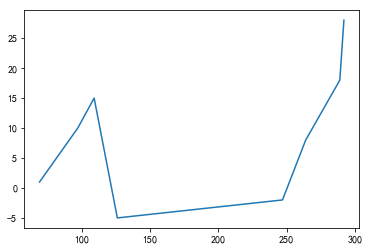

In [99]:
s.interpolate().plot()
#后面三个点不是线性的（如果几乎为线性函数，请重新运行上面的一个代码块，这是随机性导致的）

#### （b）与索引有关的插值
#### method中的index和time选项可以使插值线性地依赖索引，即插值为索引的线性函数

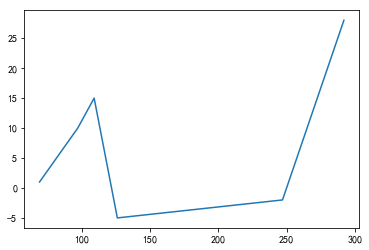

In [100]:
s.interpolate(method='index').plot()
#可以看到与上面的区别

#### 如果索引是时间，那么可以按照时间长短插值，对于时间序列将在第9章详细介绍

In [101]:
s_t = pd.Series([0,np.nan,10]
        ,index=[pd.Timestamp('2012-05-01'),pd.Timestamp('2012-05-07'),pd.Timestamp('2012-06-03')])
s_t

2012-05-01     0.0
2012-05-07     NaN
2012-06-03    10.0
dtype: float64

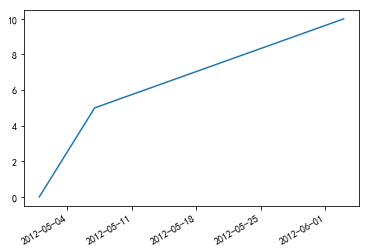

In [102]:
s_t.interpolate().plot()

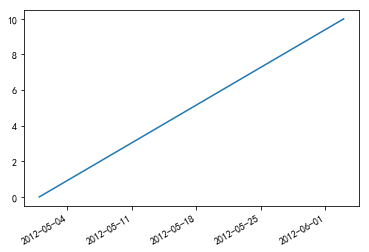

In [103]:
s_t.interpolate(method='time').plot()

### 2. 高级插值方法
#### 此处的高级指的是与线性插值相比较，例如样条插值、多项式插值、阿基玛插值等（需要安装Scipy），方法详情请看[这里](https://pandas.pydata.org/pandas-docs/version/1.0.0/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate)
#### 关于这部分仅给出一个官方的例子，因为插值方法是数值分析的内容，而不是Pandas中的基本知识：

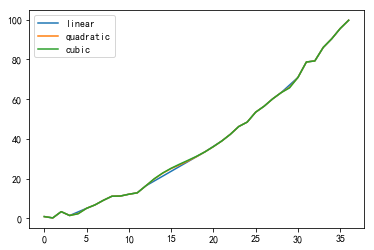

In [104]:
ser = pd.Series(np.arange(1, 10.1, .25) ** 2 + np.random.randn(37))
missing = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])
ser[missing] = np.nan
methods = ['linear', 'quadratic', 'cubic']
df = pd.DataFrame({m: ser.interpolate(method=m) for m in methods})
df.plot()

### 3. interpolate中的限制参数
#### （a）limit表示最多插入多少个

In [105]:
s = pd.Series([1,np.nan,np.nan,np.nan,5])
s.interpolate(limit=2)

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
dtype: float64

#### （b）limit_direction表示插值方向，可选forward,backward,both，默认前向

In [106]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_direction='backward')

0    1.0
1    1.0
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    NaN
8    NaN
dtype: float64

#### （c）limit_area表示插值区域，可选inside,outside，默认None

In [107]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_area='inside')

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    NaN
8    NaN
dtype: float64

In [108]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_area='outside')

0    NaN
1    NaN
2    1.0
3    NaN
4    NaN
5    NaN
6    5.0
7    5.0
8    5.0
dtype: float64

## 五、问题与练习

### 1. 问题

#### 【问题一】 如何删除缺失值占比超过25%的列？   

In [109]:
df_d = pd.DataFrame({'A':[np.nan,np.nan,np.nan],'B':[np.nan,3,2],'C':[3,2,1]})  
temp=df_d.isna().sum()/(df_d.count()+df_d.isna().sum())  
for i in temp[temp>0.25].index :  
    print(type(i),i)  
    df_d.drop(columns=i,inplace=True)  
    display(df_d)  

<class 'str'> A


,B,C
0,NaN,3
1,3.0,2
2,2.0,1


<class 'str'> B


,C
0,3
1,2
2,1


#### 【问题二】 什么是Nullable类型？请谈谈为什么要引入这个设计？  
Nullable类型是Pandas在1.0后中引入的重大改变，其目的就是为了解决之前出现的混乱局面，统一缺失值处理方法  
Nullable的好处就在于与三种缺失值np.nan、None、NaT都会被替换为统一的NA符号，且不改变数据类型。  

#### 【问题三】 对于一份有缺失值的数据，可以采取哪些策略或方法深化对它的了解？  
把带有缺失值的数据删去  
填充缺失值

### 2. 练习

#### 【练习一】现有一份虚拟数据集，列类型分别为string/浮点/整型，请解决如下问题：
#### （a）请以列类型读入数据，并选出C为缺失值的行。
#### （b）现需要将A中的部分单元转为缺失值，单元格中的最小转换概率为25%，且概率大小与所在行B列单元的值成正比。

In [116]:
pd.read_csv('data/Missing_data_one.csv').head()

,A,B,C
0,not_NaN,0.922,4.0
1,not_NaN,0.700,NaN
2,not_NaN,0.503,8.0
3,not_NaN,0.938,4.0
4,not_NaN,0.952,10.0


In [110]:
#(a)请以列类型读入数据，并选出C为缺失值的行
df = pd.read_csv('data/Missing_data_one.csv').convert_dtypes()
df[df['C'].isna()]

,A,B,C
1,not_NaN,0.700,<NA>
5,not_NaN,0.972,<NA>
11,not_NaN,0.736,<NA>
19,not_NaN,0.684,<NA>
21,not_NaN,0.913,<NA>


In [112]:
#(b)现需要将A中的部分单元转为缺失值，单元格中的最小转换概率为25%，且概率大小与所在行B列单元的值成正比。
df = pd.read_csv('data/Missing_data_one.csv').convert_dtypes()
total_b = df['B'].sum()
min_b = df['B'].min()
df['A'] = pd.Series(list(zip(df['A'].values,df['B'].values))).apply(lambda x:x[0] if np.random.rand()>0.25*x[1]/min_b else np.nan)
df.head()

,A,B,C
0,not_NaN,0.922,4
1,not_NaN,0.700,<NA>
2,not_NaN,0.503,8
3,not_NaN,0.938,4
4,not_NaN,0.952,10


#### 【练习二】 现有一份缺失的数据集，记录了36个人来自的地区、身高、体重、年龄和工资，请解决如下问题：
#### （a）统计各列缺失的比例并选出在后三列中至少有两个非缺失值的行。
#### （b）请结合身高列和地区列中的数据，对体重进行合理插值。

In [117]:
pd.read_csv('data/Missing_data_two.csv').head()

,编号,地区,身高,体重,年龄,工资
0,1,A,157.50,NaN,47.0,15905.0
1,2,B,202.00,91.80,25.0,NaN
2,3,C,169.09,62.18,NaN,NaN
3,4,A,166.61,59.95,77.0,5434.0
4,5,B,185.19,NaN,62.0,4242.0


In [113]:
#(a)统计各列缺失的比例并选出在后三列中至少有两个非缺失值的行。
df = pd.read_csv('data/Missing_data_two.csv')
df.isna().sum()/df.shape[0]

编号    0.000000
地区    0.000000
身高    0.000000
体重    0.222222
年龄    0.250000
工资    0.222222
dtype: float64

In [114]:
df_not2na = df[df.iloc[:,-3:].isna().sum(1)<=1]
df_not2na.head()

,编号,地区,身高,体重,年龄,工资
0,1,A,157.50,NaN,47.0,15905.0
1,2,B,202.00,91.80,25.0,NaN
3,4,A,166.61,59.95,77.0,5434.0
4,5,B,185.19,NaN,62.0,4242.0
5,6,A,187.13,78.42,55.0,13959.0


In [115]:
#(b)请结合身高列和地区列中的数据，对体重进行合理插值。
df_method_1 = df.copy()
for name,group in df_method_1.groupby('地区'):
    df_method_1.loc[group.index,'体重'] = group[['身高','体重']].sort_values(by='身高').interpolate()['体重']
df_method_1['体重'] = df_method_1['体重'].round(decimals=2)
df_method_1.head()

,编号,地区,身高,体重,年龄,工资
0,1,A,157.50,53.58,47.0,15905.0
1,2,B,202.00,91.80,25.0,NaN
2,3,C,169.09,62.18,NaN,NaN
3,4,A,166.61,59.95,77.0,5434.0
4,5,B,185.19,81.75,62.0,4242.0
